# Bases de vision
- author: Vincent Drevelle
- date: 2019
- summary: Ce notebook fournit quelques outils de base pour la vision par ordinateur : coordonnées homogènes, modèle sténopé, homographie entre un plan et l'image.


## Coordonnées homogènes
En géométrie projective, on rajoute une coordonnée supplémentaire $w$.

Un point 2D de coordonnées $(x,y)$ est représenté par les 3 coordonnées homogènes $\begin{pmatrix}w\cdot x\\w\cdot y\\w\end{pmatrix},\ \forall w\neq0$. On retrouve les coordonnées initiales avec $w=1$, soit $\begin{pmatrix}x\\y\\1\end{pmatrix}$.

On passe ainsi des coordonnées homogènes aux coordonnées cartésiennes en divisant chaque coordonnée par la dernière coordonnée ($w$) de la représentation homogène.

Un point 3D de coordonnées $(X,Y,Z)$ est représenté par les 4 coordonnées homogènes $\begin{pmatrix}w\cdot X \\ w\cdot Y \\ w\cdot Z\\ w\end{pmatrix},\ \forall w\neq0$, en particulier $\begin{pmatrix}X\\Y\\Z\\1\end{pmatrix}$.

Le cas particulier $w=0$ permet de représenter des points situés à l'infini (comme les étoiles par exemple).

Les coordonnées homogènes permettent de représenter les transformations rigides (rotation et translation), ainsi que la projection perspective comme des opérations linéaires. Une étape finale de normalisation (division par $w$) est nécessaire en fin de calcul pour retrouver les coordonnées cartésiennes.

## Le modèle sténopé
Le modèle classique utilisé pour représenter une caméra perspective est le modèle sténopé ("pinhole model").

Exprimées en coordonnées homogènes, les coordonnées $(u,v)$ en pixels d'un point sur la rétine (capteur) de la caméra sont données à partir de ses coordonnées $(X,Y,Z)$ dans le repère monde par 
$$ \begin{pmatrix}u\\v\\1\end{pmatrix} = K\ \Pi\ ^cT_w \begin{pmatrix}X\\Y\\Z\\1\end{pmatrix} $$

### $^cT_w$ : Matrice de transformation du repère monde vers le repère caméra.
Le repère caméra est défini tel que $\vec x$ pointe vers la gauche de l'image, $\vec y$ vers le bas, et $\vec z$ part du centre optique de la caméra vers l'avant.

$$\ ^cT_w = \begin{pmatrix}r_{11} & r_{12} & r_{13} & t_x \\
         r_{21} & r_{22} & r_{23} & t_y \\
         r_{31} & r_{32} & r_{33} & t_z \\
         0      & 0      & 0      & 1\end{pmatrix} $$
 
Les $r_{ij}$ correspondent à une matrice de rotation, et les $t_i$ correspondent à la translation. Cette matrice définit la *pose* de la caméra.

### $\Pi$ : Matrice de projection
$$\Pi = \begin{pmatrix}1&0&0&0\\0&1&0&0\\0&0&1&0\end{pmatrix}$$

### K : Matrice des paramètres intrinsèques de la caméra
$$K = \begin{pmatrix}k_u f & 0 & u_0 \\ 0 & k_v f & v_0 \\ 0 & 0 & 1\end{pmatrix}$$
Ces paramètres sont généralement déterminés lors d'une étape de calibration, à l'aide d'une mire.

In [1]:
import numpy as np

# Tranformation repère monde -> repère robot
# <=> pose du robot dans le monde
R = np.eye(3)
T = np.array([0,0,0])
rTw = np.vstack((np.hstack((R, T[:,np.newaxis])),
                 np.array([0, 0, 0, 1])))
# Transformation repère robot -> repère caméra : Zc=Xr, Xc=-Yr, Yc=-Zr
cTr = np.array([[0, -1, 0, 0],
                [0, 0, -1, 0],
                [1, 0, 0, 0],
                [0, 0, 0, 1]])
# Transformation repère monde -> repère caméra
cTw = cTr @ rTw

# Matrice de projection
Pi = np.eye(3,4)

# Paramètres intrinsèques de la caméra (ici 320x240, env 100° de champ de vue)
K = np.array([[265.23, 0.0, 160.5],
              [0.0, 265.23, 120.5],
              [0.0, 0.0, 1.0]])

# Projection du monde dans l'image
P = K @ Pi @ cTw

In [2]:
# Exemple : 3 points A, B, C dans le monde
# (coordonnées homogènes, on ajoute un '1' en 4ième coordonnée)
A = np.array([6, 3, 1, 1])
B = np.array([5, -2, 0.5, 1])
C = np.array([3, 1, 1, 1])
print(f'Point monde :\nA = {A}')

# Projection
a = P @ A
b = P @ B
c = P @ C
print(f'Point projeté :\na = {a} (avant normalisation)')

# Normalisation
# (on revient à la forme (u,v,1) en divisant par la dernière coordonnée w)
for x in [a,b,c]:
    x /= x[2]
print(f'a = {a} (après normalisation)')

Point monde :
A = [6 3 1 1]
Point projeté :
a = [167.31 457.77   6.  ] (avant normalisation)
a = [27.885 76.295  1.   ] (après normalisation)


In [3]:
%matplotlib inline
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt

def plot_world_and_image():
    # Affichage
    fig = plt.figure(figsize=[15,5])
    ax = fig.add_subplot(121, projection='3d')

    # Points monde
    for X in [A,B,C]:
        ax.scatter(X[0], X[1], X[2])
        ax.plot([X[0], X[0]], [X[1], X[1]], [X[2], 0], color='k', linestyle=':', linewidth=1)
    # Camera et champ de vue
    ax.scatter(0, 0, 0, c='k')
    ax.plot([0, 5*np.cos(0.9)], [0, 5*np.sin(0.9)], [0, 0], color='k', linestyle='--', linewidth=1)
    ax.plot([0, 5*np.cos(-0.9)], [0, 5*np.sin(-0.9)], [0, 0], color='k', linestyle='--', linewidth=1)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title('Monde')

    ax2 = fig.add_subplot(122)
    # Points image
    for x in [a,b,c]:
        ax2.scatter(x[0], x[1])
    ax2.axis([0, 320, 240, 0]);
    ax2.set_title('Image');
    
    return fig

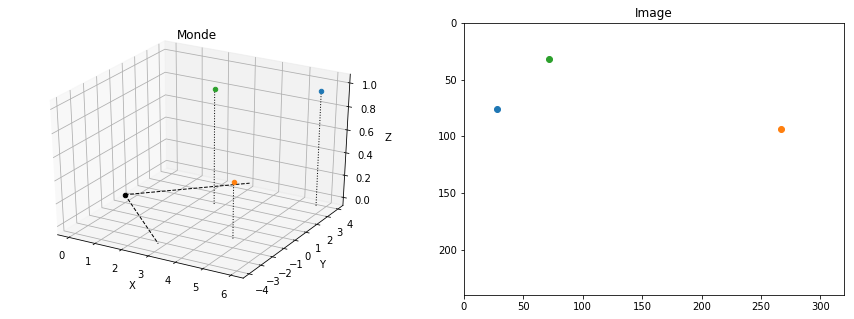

In [4]:
plot_world_and_image();

## Reprojection d'un point image dans un plan
La connaissance des coordonnées $(u,v)$ de la projection d'un point dans l'image dans détermine un *rayon* sur lequel le point se trouve dans le monde (demi-droite partant du centre optique de la caméra).

Si on sait également que le point se trouve dans un plan particulier du monde (par exemple le sol), alors le point se trouve à l'insersection du rayon et du plan, dont on peut determiner les coordonnées.

Soient $(X_p, Y_p)$ les coodonnées du point dans un repère $\mathcal F_p$ associé au plan (tel que $Z_p=0$), et $^wT_p$ la transformation du repère $\mathcal F_p$ au repère monde $\mathcal F_w$. L'équation de projection peut s'écrire 
$$\begin{pmatrix}u\\v\\1\end{pmatrix} = K\ \Pi\ ^cT_w\ ^wT_p \begin{pmatrix}X_p\\Y_p\\0\\1\end{pmatrix} $$

Soit $$\begin{pmatrix}u\\v\\1\end{pmatrix} = K\ \Pi\ ^cT_w\ ^wT_p\ P_p \begin{pmatrix}X_p\\Y_p\\1\end{pmatrix} ,\textrm{ avec } P_p=\begin{pmatrix}1&0&0\\0&1&0\\0&0&0\\0&0&1\end{pmatrix}$$

On peut donc obtenir les coordonnées homogènes du point dans le repère du plan en résolvant un système linéaire :
$$\begin{pmatrix}X_p\\Y_p\\1\end{pmatrix} = \left(K\ \Pi\ ^cT_w\ ^wT_p\ P_p\right)^{-1}\begin{pmatrix}u\\v\\1\end{pmatrix}$$

Les coordonnées $(X,Y,Z)$ du point dans le repère monde s'obtiennent facilement depuis les coordonnées dans le repère du plan :

$$\begin{pmatrix}X\\Y\\Z\\1\end{pmatrix} =\ ^wT_p\ P_p \begin{pmatrix}X_p\\Y_p\\1\end{pmatrix}$$
$$\begin{pmatrix}X\\Y\\Z\\1\end{pmatrix} =\ ^wT_p\ P_p\ \left(K\ \Pi\ ^cT_w\ ^wT_p\ P_p\right)^{-1}\begin{pmatrix}u\\v\\1\end{pmatrix}$$

In [5]:
# Exemple : points sur la route
# On détecte deux lignes dans l'image, on veut les reprojeter dans le monde
# en supposant qu'elles sont sur le sol (plan z=0)

# Le support de caméra est à 15 cm de hauteur et tourné de 10 degrés vers le bas
from numpy import pi, cos, sin
θ = 10.0 * pi / 180.0
Rcam = np.array([[cos(θ),  0, sin(θ)],
                 [0,       1, 0     ],
                 [-sin(θ), 0, cos(θ)]])
Tcam = np.array([0,0,0.15])
camTr = np.vstack((np.hstack((Rcam.T, -Rcam.T @ Tcam[:,np.newaxis])),
                 np.array([0, 0, 0, 1])))
cTw = cTr @ camTr @ rTw

In [6]:
# Le plan considéré est z=0 dans le repère monde, la transformation est donc l'identité
wTp = np.eye(4)
# Matrice Pp
Pp = np.eye(4)[:, [0,1,3]]

# Matrice de transformation image -> plan
I2P = wTp @ Pp @ np.linalg.inv(K @ Pi @ cTw @ wTp @ Pp)

In [7]:
# Points dans l'image
a1 = [25, 230, 1];  a2 = [70, 170, 1]
b1 = [270, 230, 1]; b2 = [220, 170, 1]

# Points dans le repère monde
A1 = I2P @ a1; A2 = I2P @ a2;
B1 = I2P @ b1; B2 = I2P @ b2;
# Normalisation
for (X1,X2) in [(A1,A2), (B1,B2)]:
    X1 /= X1[3]; X2 /= X2[3]

print(f"Dans l'image, a1 = {a1[0:2]}")
print(f"Dans le monde, A1 = {A1[0:3]} (en supposant qu'il est sur le plan de la route)")

Dans l'image, a1 = [25, 230]
Dans le monde, A1 = [0.23605931 0.13207215 0.        ] (en supposant qu'il est sur le plan de la route)


In [8]:
# Affichage exemple homographie image route
def plot_image_and_map():
    fig = plt.figure(figsize=[15,5])
    ax1 = fig.add_subplot(121)
    for (x1,x2) in [(a1,a2), (b1,b2)]:
        ax1.plot([x1[0], x2[0]], [x1[1], x2[1]], '*-')
    ax1.axis([0, 320, 240, 0]);
    ax1.set_title('Image')

    ax2 = fig.add_subplot(122)
    for (X1,X2) in [(A1,A2), (B1,B2)]:
        X1 /= X1[3]; X2 /= X2[3]
        ax2.plot([X1[0],X2[0]], [X1[1],X2[1]], '*-')
    ax2.plot(0, 0, '.k', markersize=15); ax2.plot([0,0.1,0.08,0.08,0.1], [0,0,-0.01,0.01,0], 'k')
    ax2.set_title("Monde (vue d'oiseau)")
    ax2.set_xlabel('X'); ax2.set_ylabel('Y')
    ax2.axis('equal');
    return fig

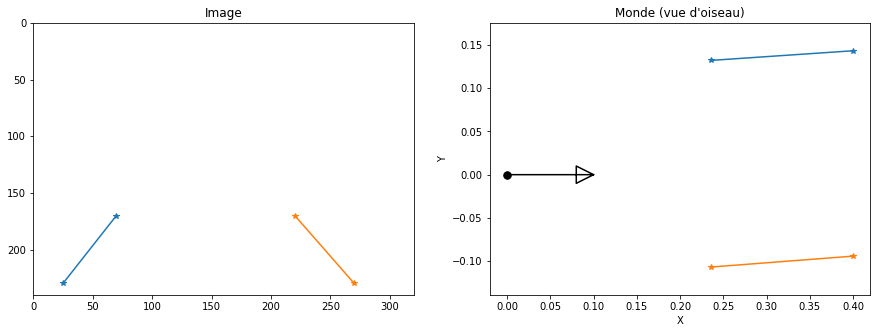

In [9]:
plot_image_and_map();